In [1]:
import os

from collections import defaultdict

import matplotlib              as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot       as plt
import matplotlib.ticker       as mticker

import numpy                   as np

import radical.analytics       as ra
import radical.pilot           as rp
import radical.utils           as ru

from radical.analytics.utils import to_latex

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!rm -rf ~/.radical/analytics/cache

fonts_dir = os.path.join(os.getcwd(), 'fonts')
# see: https://github.com/radical-cybertools/tutorials/tree/main/src/devel

if os.path.isdir(fonts_dir):
    try:
        fm.fontManager.addfont(fm.findSystemFonts(fonts_dir)[0])

        plt.style.use(ra.get_mplstyle('radical_mpl'))
        mpl.rcParams['text.usetex'] = False
        mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
        mpl.rcParams['font.family'] = 'serif'
    except Exception as e:
        print(f'WARNING: font is not set ({e})')
else:
    print('WARNING: directory with font(s) not found')

# Sessions

In [4]:
sessions = {
    '1n': {
        'sid': 'rp.session.polaris-login-02.matitov.019911.0002',
        'd_full': '1 node with request tasks (64 tasks), 1 node for ollama service'
    },
    '2n': {
        'sid': 'rp.session.polaris-login-04.matitov.019911.0003',
        'd_full': '2 nodes with request tasks (128 tasks), 1 node for ollama service'
    },
    '4n': {
        'sid': 'rp.session.polaris-login-04.matitov.019911.0004',
        'd_full': '4 nodes with request tasks (256 tasks), 1 node for ollama service'
    },
    '8n': {
        'sid': 'rp.session.polaris-login-04.matitov.019911.0005',
        'd_full': '8 nodes with request tasks (512 tasks), 1 node for ollama service'
    },
    '1ta': {
        'sid': 'rp.session.polaris-login-04.matitov.019914.0000',
        'd_full': '1 node with a single request task (base prompts), 1 node for ollama service'
    },
    '1tb': {
        'sid': 'rp.session.polaris-login-02.matitov.019914.0003',
        'd_full': '1 node with a single request task (base prompts), 1 node for ollama service'
    },
    '1tc': {
        'sid': 'rp.session.polaris-login-02.matitov.019915.0000',
        'd_full': '1 node with a single request task (base prompts), 1 node for ollama service'
    },
    '8npa': {
        'sid': 'rp.session.polaris-login-04.matitov.019914.0001',
        'd_full': '8 nodes with a single probe request task and a set of concurrent request tasks (512 tasks), 1 node for ollama service'
    },
    '8npb': {
        'sid': 'rp.session.polaris-login-02.matitov.019915.0003',
        'd_full': '8 nodes with a single probe request task and a set of concurrent request tasks (512 tasks), 1 node for ollama service'
    }
}

# Get session tracing events

In [5]:
data = {}

for k, v in sessions.items():
    session = ra.Session(v['sid'], 'radical.pilot')
    data[k] = {'session': session,
               'pilot'  : session.filter(etype='pilot', inplace=False).get()[0],
               'tasks'  : session.filter(etype='task',  inplace=False)}

    data[k]['sid'] = v['sid']
    data[k]['pid'] = data[k]['pilot'].uid
    data[k]['smt'] = data[k]['pilot'].cfg['resource_details']['rm_info']['threads_per_core']

In [6]:
def run_metrics(data, ntasks=None):
    ttx = data['tasks'].duration(event=[{ru.EVENT: 'task_run_start'},
                                        {ru.EVENT: 'task_run_stop'}])
    runtime = data['pilot'].duration(event=[{ru.EVENT: 'bootstrap_0_start'},
                                            {ru.EVENT: 'bootstrap_0_stop'}])
    print(f'TOTAL RUNTIME: {round(runtime)}s | RCT OVH: {round(runtime - ttx)}s')
    
    if ntasks and ntasks > 1:
        task_idx = ntasks - 1
        print(f'# Following rates are based on the first {ntasks} tasks')
    else:
        task_idx = -1
        ntasks = None
        print(f'# Following rates are based on all tasks')
    
    session = data['session']

    # calculate scheduling throughput (for the first N tasks or for all tasks)
    ts_schedule_ok = sorted(session.timestamps(event={ru.STATE: 'AGENT_SCHEDULING'}))
    total_tasks = ntasks or len(ts_schedule_ok)
    print('scheduling rate: ', total_tasks / (ts_schedule_ok[task_idx] - ts_schedule_ok[0]))

    # calculate launching rate (for the first N tasks or for all tasks)
    ts_agent_executing = sorted(session.timestamps(event=[{ru.EVENT: 'launch_submit'}]))
    total_tasks = ntasks or len(ts_agent_executing)
    print('launching rate: ', total_tasks / (ts_agent_executing[task_idx] - ts_agent_executing[0]))

In [7]:
for k, v in data.items():
    try:
        print('### ', sessions[k]['d_full'])
        run_metrics(v, ntasks=None)
    except Exception as e:
        print(e)

###  1 node with request tasks (64 tasks), 1 node for ollama service
TOTAL RUNTIME: 94s | RCT OVH: 19s
# Following rates are based on all tasks
scheduling rate:  180.61338248095683
launching rate:  111.10651696033847
###  2 nodes with request tasks (128 tasks), 1 node for ollama service
TOTAL RUNTIME: 160s | RCT OVH: 21s
# Following rates are based on all tasks
scheduling rate:  271.0611772957267
launching rate:  112.21748923539985
###  4 nodes with request tasks (256 tasks), 1 node for ollama service
TOTAL RUNTIME: 283s | RCT OVH: 21s
# Following rates are based on all tasks
scheduling rate:  417.2690437701679
launching rate:  113.25278329733652
###  8 nodes with request tasks (512 tasks), 1 node for ollama service
TOTAL RUNTIME: 521s | RCT OVH: 20s
# Following rates are based on all tasks
scheduling rate:  487.69628112192373
launching rate:  106.64363087108075
###  1 node with a single request task (base prompts), 1 node for ollama service
TOTAL RUNTIME: 45s | RCT OVH: 21s
# Followin

# Resource Utilization

In [8]:
Y_MIN = 64  # service task is not plotted (nt part of the TMGR list of tasks)

def plot_utilization(data, resources=None, save=True, with_metrics=False):

    DURATIONS = {
        'boot'        : [{ru.EVENT: 'bootstrap_0_start'},
                         {ru.EVENT: 'bootstrap_0_ok'   }],
        'agent_setup' : [{ru.EVENT: 'bootstrap_0_ok'   },
                         {ru.STATE: rp.PMGR_ACTIVE     }],
        'exec_queue'  : [{ru.STATE: rp.AGENT_SCHEDULING},
                         {ru.STATE: rp.AGENT_EXECUTING }],
        'exec_prep'   : [{ru.STATE: rp.AGENT_EXECUTING },
                         {ru.EVENT: 'task_run_start'   }],
        'exec_rp'     : [{ru.EVENT: 'task_run_start'   },
                         {ru.EVENT: 'launch_start'     }],
        'exec_sh'     : [{ru.EVENT: 'launch_start'     },
                         {ru.EVENT: 'launch_submit'    }],
        'exec_launch' : [{ru.EVENT: 'launch_submit'    },
                         {ru.EVENT: 'exec_start'       }],
        'exec_cmd'    : [{ru.EVENT: 'exec_start'       },
                         {ru.EVENT: 'exec_stop'        }],
        'exec_prompt' : [{ru.EVENT: 'ollama_prompt_start'},
                         {ru.EVENT: 'ollama_prompt_stop' }],
        'exec_finish' : [{ru.EVENT: 'exec_stop'        },
                         {ru.EVENT: 'launch_collect'   }],
        'term_sh'     : [{ru.EVENT: 'launch_collect'   },
                         {ru.EVENT: 'launch_stop'      }],
        'term_rp'     : [{ru.EVENT: 'launch_stop'      },
                         {ru.EVENT: 'task_run_stop'    }],
        'unschedule'  : [{ru.EVENT: 'task_run_stop'    },
                         {ru.EVENT: 'unschedule_stop'  }]
    }

    METRICS = [
        ['Bootstrap',     ['boot', 'agent_setup'],        '#c6dbef'],
        #['Warmup',        ['warm'],                       '#f0f0f0'],
        ['Schedule',      ['exec_queue', 'unschedule'],   '#c994c7'],
        ['Prep',          ['exec_prep', 'exec_rp', 'exec_sh',
                           'term_sh', 'term_rp'],         '#fdbb84'],
        # ['Launch method', ['exec_launch', 'exec_finish'], '#ff9999'],
        ['Launch',        ['exec_launch'],                '#ff9999'],
        ['Running',       ['exec_cmd'],                   '#88bb88'],
        ['Prompting',       ['exec_prompt'],                   '#599c59'],
        #['Cooldown',      ['drain'],                      '#addd8e']
    ]
    
    correction = 0.5
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    rtype_info = {'cpu': {'label': 'Number of CPU cores',
                          'formatter': lambda z, pos: int(z / data['smt'])},
                  'gpu': {'label': 'Number of GPUs',
                          'formatter': None}}
    
    # fig, axarr = plt.subplots(1, len(rtypes), figsize=(
    #     ra.get_plotsize(256 * len(rtypes), subplots=(1, len(rtypes)))))
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))
    
    exp = ra.Experiment([data['session']], stype='radical.pilot')
    # get the start time of each pilot
    p_zeros = ra.get_pilots_zeros(exp)

    legend = None
    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr
        
        x_min, x_max, y_min, y_max = None, None, None, None

        consumed = rp.utils.get_consumed_resources(
            data['session'], rtype, {'consume': DURATIONS})

        # generate the subplot with labels
        legend, patches, x, y = ra.get_plot_utilization(
            METRICS, {sid: consumed}, p_zeros[sid][pid], sid)

        # place all the patches, one for each metric, on the axes
        for patch in patches:
            patch.set_y(patch.get_y() + correction)
            ax.add_patch(patch)

        x_min = x['min'] if not x_min else min(x_min, x['min'])
        x_max = x['max'] if not x_max else max(x_max, x['max'])
        y_min = Y_MIN
        # y_min = y['min'] if not y_min else min(y_min, y['min'])
        y_max = y['max'] if not y_max else max(y_max, y['max'])
    
        ax.set_xlim([x_min, int(x_max)])
        ax.set_ylim([y_min + correction, int(y_max + correction)])

        ax.xaxis.set_major_locator(mticker.MaxNLocator(int(x_max // 20)))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(min (y_max, 4)))

        if rtype_info[rtype]['formatter'] is not None:
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(
                rtype_info[rtype]['formatter']))

        ax.set_ylabel(to_latex(rtype_info[rtype]['label']), fontsize=11)
        ax.set_title(' ')  # placeholder

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(legend, [m[0] for m in METRICS],
               loc='upper center',
               #bbox_to_anchor=(0.5, 0.95),
               ncol=len(METRICS)) 
    
    plt.tight_layout()
    plt.show()
    
    plot_name = '%s.ru.png' % '.'.join(sid.rsplit('.', 2)[1:])
    fig.savefig(plot_name)
    
    if with_metrics:
        # print resource utilization metrics
        for rtype in rtypes:
            _, _, stats_abs, stats_rel, info = data['session'].utilization(
                METRICS, rtype, {'consume': DURATIONS})
            print('%s RU: ' % rtype.upper(), info)

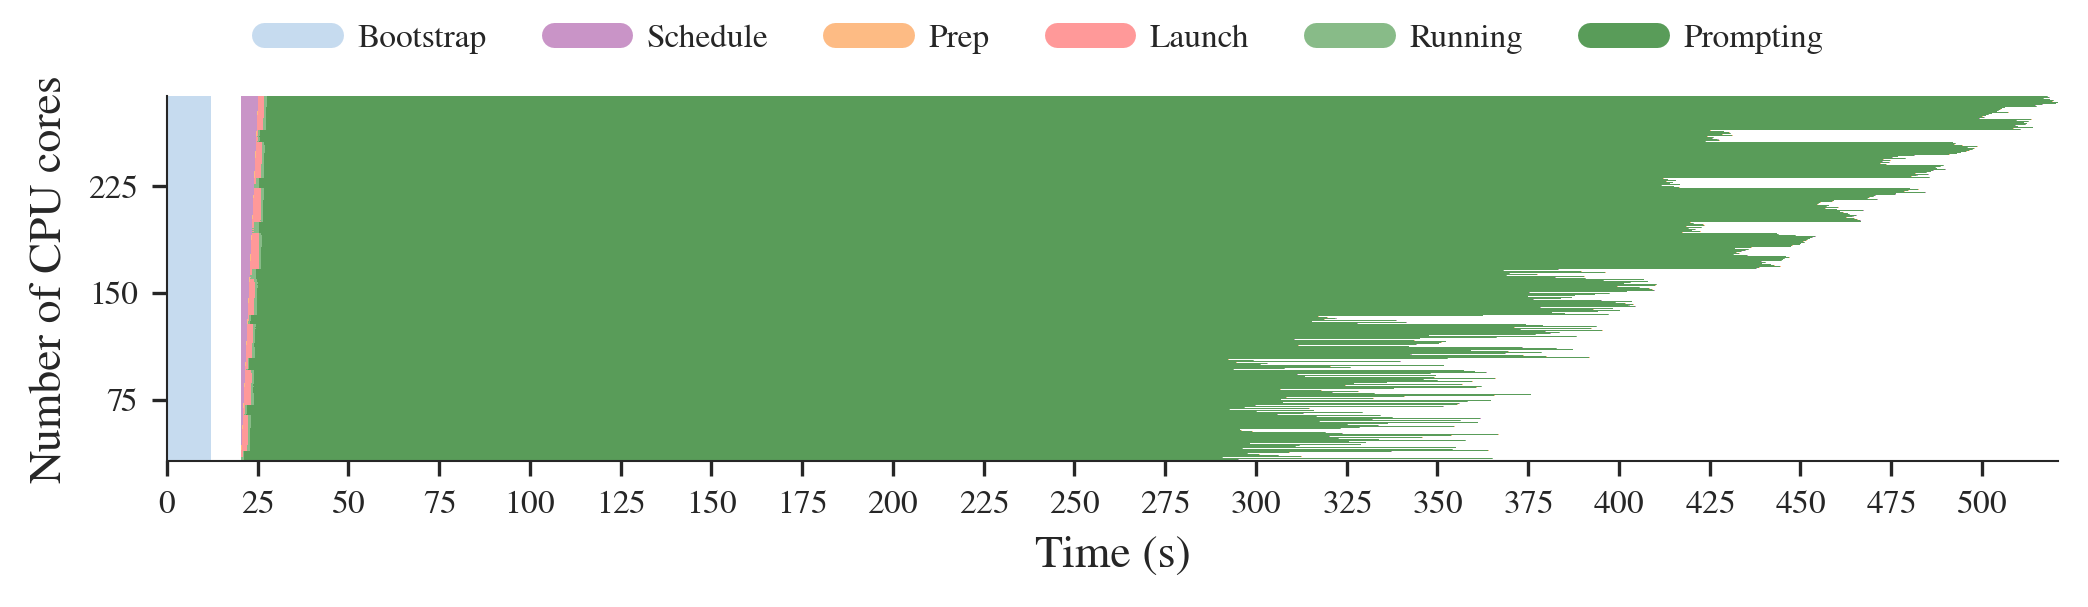

In [9]:
for k in ['8n']: #['1n', '2n', '4n', '8n']:
    plot_utilization(data[k], resources=['cpu'], save=True, with_metrics=False)

# Resource Utilization - STACKED

In [10]:
def plot_utilization_stack(data, resources=None, save=True):

    tmap = {
        'pilot':  [
            [{1: 'bootstrap_0_start'}     , 'system'     , 'Bootstrap'  ],
            [{5: 'PMGR_ACTIVE'}           , 'Bootstrap'  , 'Idle'       ],
            [{1: 'cmd', 6: 'cancel_pilot'}, 'Idle'       , 'Term'       ],
            [{1: 'bootstrap_0_stop'}      , 'Term'       , 'system'     ],
            [{1: 'sub_agent_start'}       , 'Idle'       , 'agent'      ],
            [{1: 'sub_agent_stop'}        , 'agent'      , 'Term'       ]
        ],
        'task': [
            [{1: 'schedule_ok'}           , 'Idle'       , 'Exec setup' ],
            [{1: 'exec_start'}            , 'Exec setup' , 'Running'    ],
            [{1: 'exec_stop'}             , 'Running'    , 'Exec setup' ],
            [{1: 'unschedule_stop'}       , 'Exec setup' , 'Idle'       ]
        ],
    }
    metrics = [ 
        # metric,      line color, alpha, fill color, alpha
        ['Bootstrap',  ['#c6dbef', 0.0, '#c6dbef', 1]],
        ['Exec setup', ['#fdbb84', 0.0, '#fdbb84', 1]],
        ['Running',    ['#88bb88', 0.0, '#88bb88', 1]],
        ['Idle',       ['#f0f0f0', 0.0, '#f0f0f0', 1]]
    ]

    to_stack = [m[0] for m in metrics]
    to_plot = {m[0]: m[1] for m in metrics}
    
    sid = data['sid']
    pid = data['pid']
    
    rtypes = ru.as_list(resources) or ['cpu', 'gpu']
    fig, axarr = plt.subplots(len(rtypes), 1, figsize=(7, 2 * len(rtypes)))

    patches = []
    legend = []

    p_resrc, series, x = ra.get_pilot_series(
        data['session'], data['pilot'], tmap, rtypes, True)

    for idx, rtype in enumerate(rtypes):
        
        if len(rtypes) > 1:
            ax = axarr[idx]
        else:
            ax = axarr

        # stack timeseries for each metrics into areas
        areas = ra.stack_transitions(series, rtype, to_stack)

        # plot individual metrics
        prev_m = None
        for m in areas:

            if m not in to_plot:
                if m != 'time':
                    print('skip', m)
                continue

            lcol = to_plot[m][0]
            lalpha = to_plot[m][1]
            pcol = to_plot[m][2]
            palpha = to_plot[m][3]

            # plot the (stacked) areas
            ax.step(np.array(areas['time']), np.array(areas[m]),
                    where='post', label=m,
                    color=lcol, alpha=lalpha, linewidth=1.0)

            # fill first metric toward 0, all others towards previous line
            if not prev_m:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            else:
                patch = ax.fill_between(
                    areas['time'], areas[m],
                    areas[prev_m],
                    step='post', label=m,
                    linewidth=0.0,
                    color=pcol, alpha=palpha)

            # remember patches for legend
            if len(legend) < len(metrics):
                legend.append(m)
                patches.append(patch)

            # remember this line to fill against
            prev_m = m

        ax.set_xlim([x['min'], x['max']])
        ax.set_ylim([0, 110])

        ax.yaxis.set_major_locator(
            mticker.MaxNLocator(3, steps=[5, 10]))

        ax.set_ylabel('%s (%%)' % rtype.upper(), fontsize=12)

        for ax in fig.get_axes():
            ax.label_outer()

    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)

    fig.legend(patches, legend, 
               loc='upper center',
               #bbox_to_anchor=(0.5, 1.05),
               ncol=len(metrics),
               fancybox=True, shadow=False, fontsize=11,
               frameon=True, facecolor='white')

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.ru.stack.png' % '.'.join(sid.rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

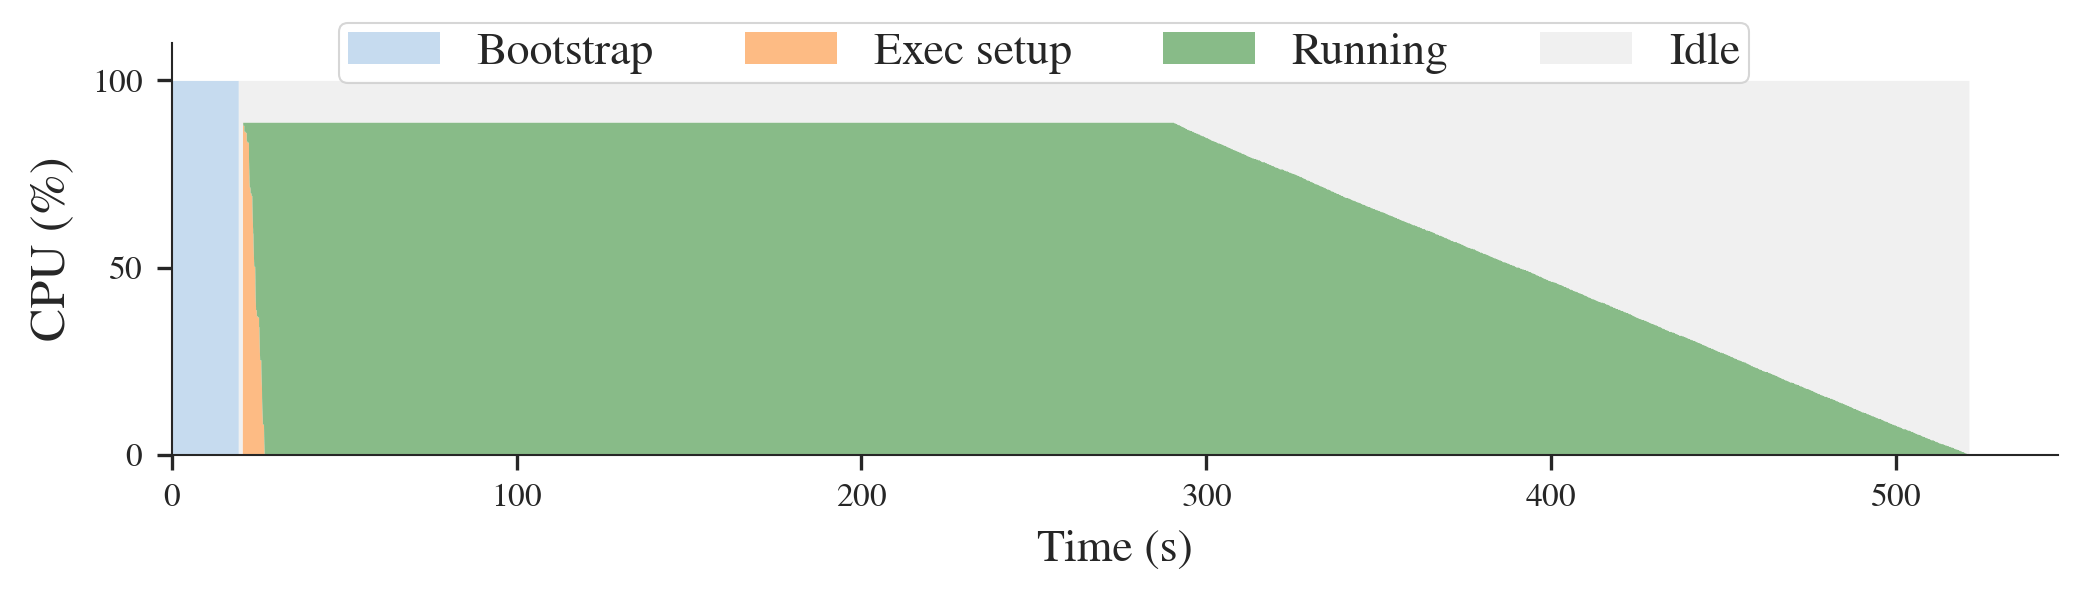

In [11]:
for k in ['8n']: #['1n', '2n', '4n', '8n']:
    plot_utilization_stack(data[k], resources=['cpu'], save=True)

# Concurrency
Number of tasks within a certain phase during a runtime period.

In [12]:
def plot_concurrency(data, save=True):
    
    events = {'Tasks quering': [{ru.EVENT: 'ollama_req_start'},
                                   {ru.EVENT: 'ollama_req_stop'}],
              'Tasks prompting'   : [{ru.EVENT: 'ollama_prompt_start'},
                                   {ru.EVENT: 'ollama_prompt_stop'}]}

    # events = {'Tasks scheduling': [{ru.STATE: 'AGENT_SCHEDULING'},
    #                                {ru.EVENT: 'schedule_ok'}],
    #           'Tasks running'   : [{ru.EVENT: 'exec_start'},
    #                                {ru.EVENT: 'exec_stop'}]}

    # events = {'Tasks placed'   : [{ru.EVENT: 'launch_submit'},
    #                               {ru.EVENT: 'launch_collect'}]}
    # events = {'Job steps launched': [{ru.EVENT: 'launch_submit'},
    #                                  {ru.EVENT: 'exec_start'}]}

    fig, ax = plt.subplots(1, 1, figsize=(7, 2))

    pilot_starttime = data['pilot'].\
        timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

    legend = []
    for e_name in events:
        time_series = data['session'].concurrency(event=events[e_name], sampling=0.0001)
        ax.plot([e[0] - pilot_starttime for e in time_series],
                [e[1] for e in time_series],
                label=ra.to_latex(e_name), lw=1)
        legend.append(e_name)

    ax.set_ylabel(to_latex('Number of tasks'), fontsize=11)
    ax.set_xlabel(to_latex('Time (s)'), fontsize=11)
        
    fig.legend(legend,
               loc='upper center',
               bbox_to_anchor=(0.75, 1.05),
               ncol=len(legend), 
               fontsize=11)

    plt.tight_layout()
    plt.show()

    if save:
        plot_name = '%s.concurrency.png' % '.'.join(data['sid'].rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

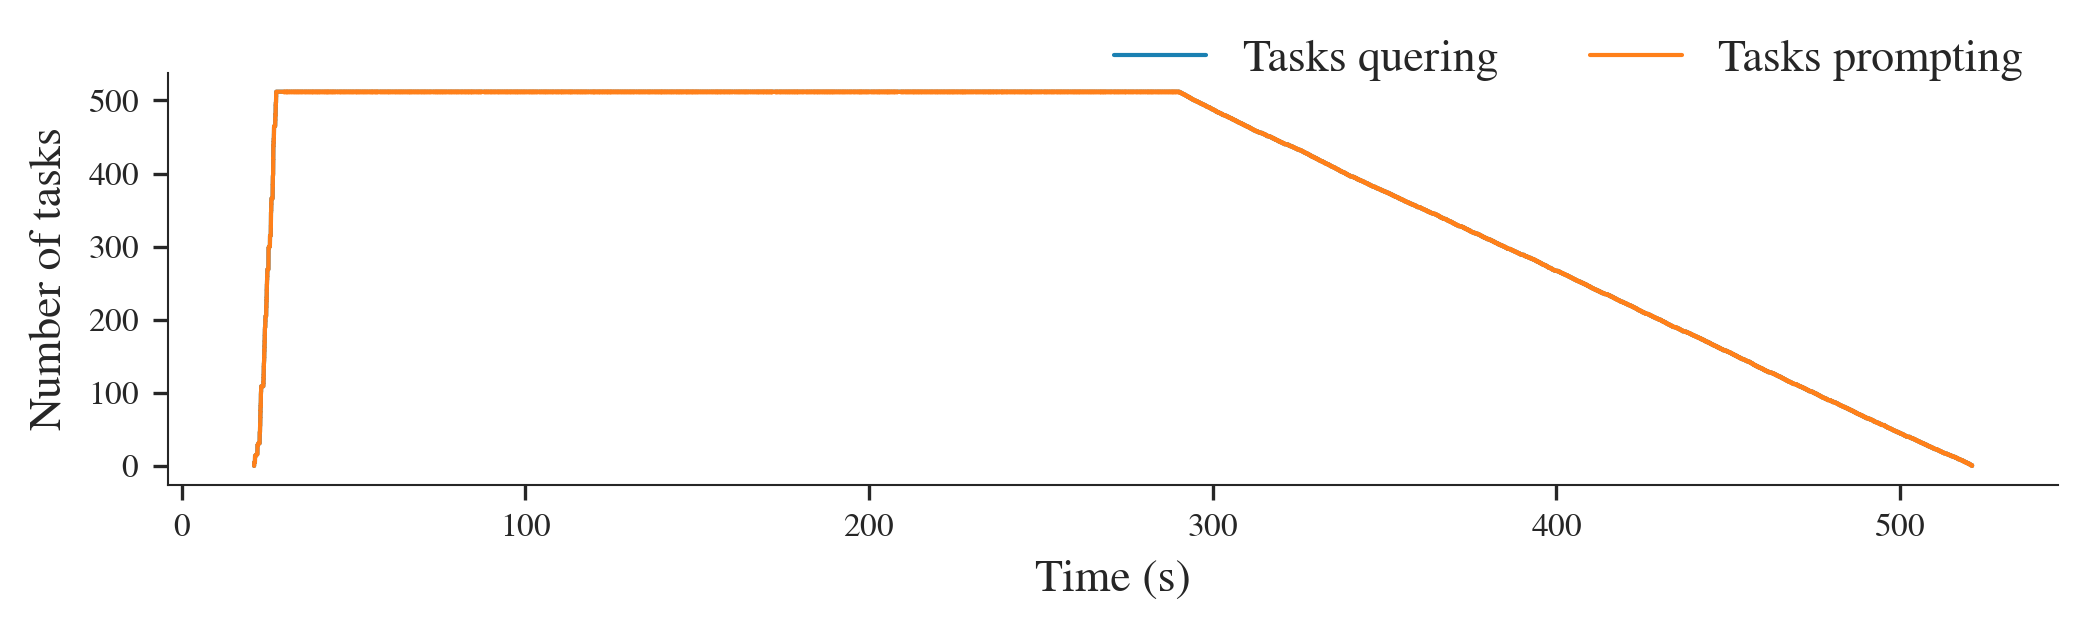

In [13]:
for k in ['8n']: #['1n', '2n', '4n', '8n']:
    plot_concurrency(data[k], save=True)

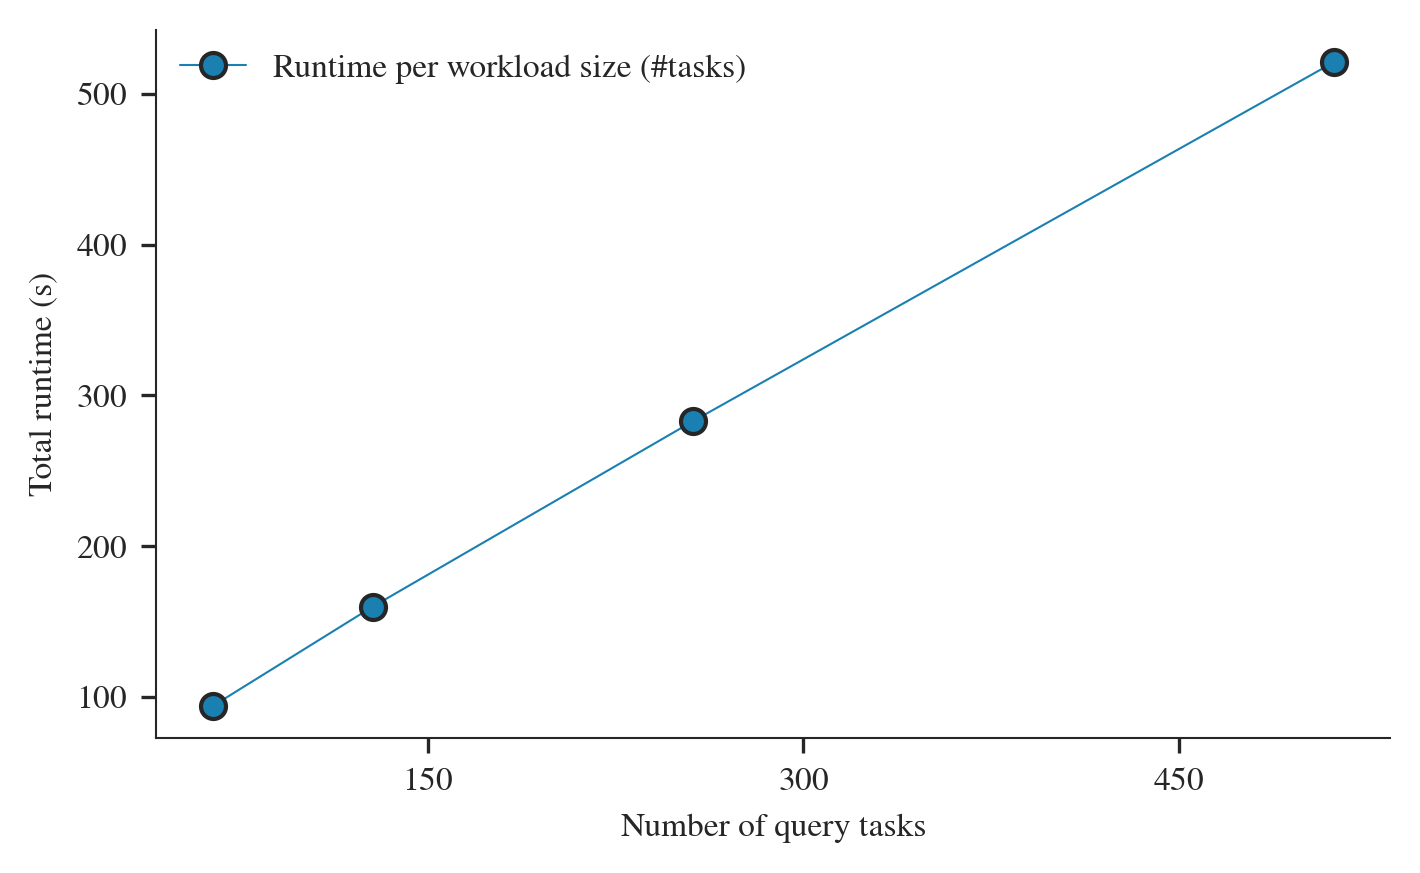

In [14]:
d = [(64,  94),
     (128, 160),
     (256, 283),
     (512, 521)]

fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

_x, _y = zip(*d)
ax.plot(_x, _y, label='Runtime per workload size (#tasks)', marker='o')

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.legend()

ax.xaxis.set_major_locator(mticker.MaxNLocator(4))

ax.set_ylabel('Total runtime (s)')
ax.set_xlabel('Number of query tasks')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join('.', 'runtimes.png'))

# Plot rate

In [15]:
def exec_rate(data, save=True):
    events = {'Task Exec Completion': {ru.EVENT: 'exec_stop' }}
    colors = {'Task Exec Completion': '#55CC55'}
    
    # events = {'Task Executing'     : {ru.STATE: rp.AGENT_EXECUTING}}
    #           # 'Task Exec Completion': {ru.EVENT: 'exec_stop' }}


    rates = {e_name: data['session'].rate(event=event, sampling=2.)
             for e_name, event in events.items()}

    fig, ax = plt.subplots(figsize=ra.get_plotsize(500))

    legend = []
    for e_name, rate_series in rates.items():
        x = [e[0] for e in rate_series]
        y = [e[1] for e in rate_series]
        ax.plot(x, y, color=colors[e_name], label=ra.to_latex(e_name), lw=1)
        legend.append(e_name + ' (%s tasks)' % len(data['tasks'].list('uid')))

    fig.legend(legend,
               loc='upper center',
               bbox_to_anchor=(0.75, 1.05),
               ncol=len(legend), 
               fontsize=11)

    ax.set_ylabel('Rate (#tasks/sec)')
    ax.set_xlabel('Time (s)')
    plt.tight_layout()

    if save:
        plot_name = '%s.rate.png' % '.'.join(data['sid'].rsplit('.', 2)[1:])
        fig.savefig(os.path.join('.', plot_name))

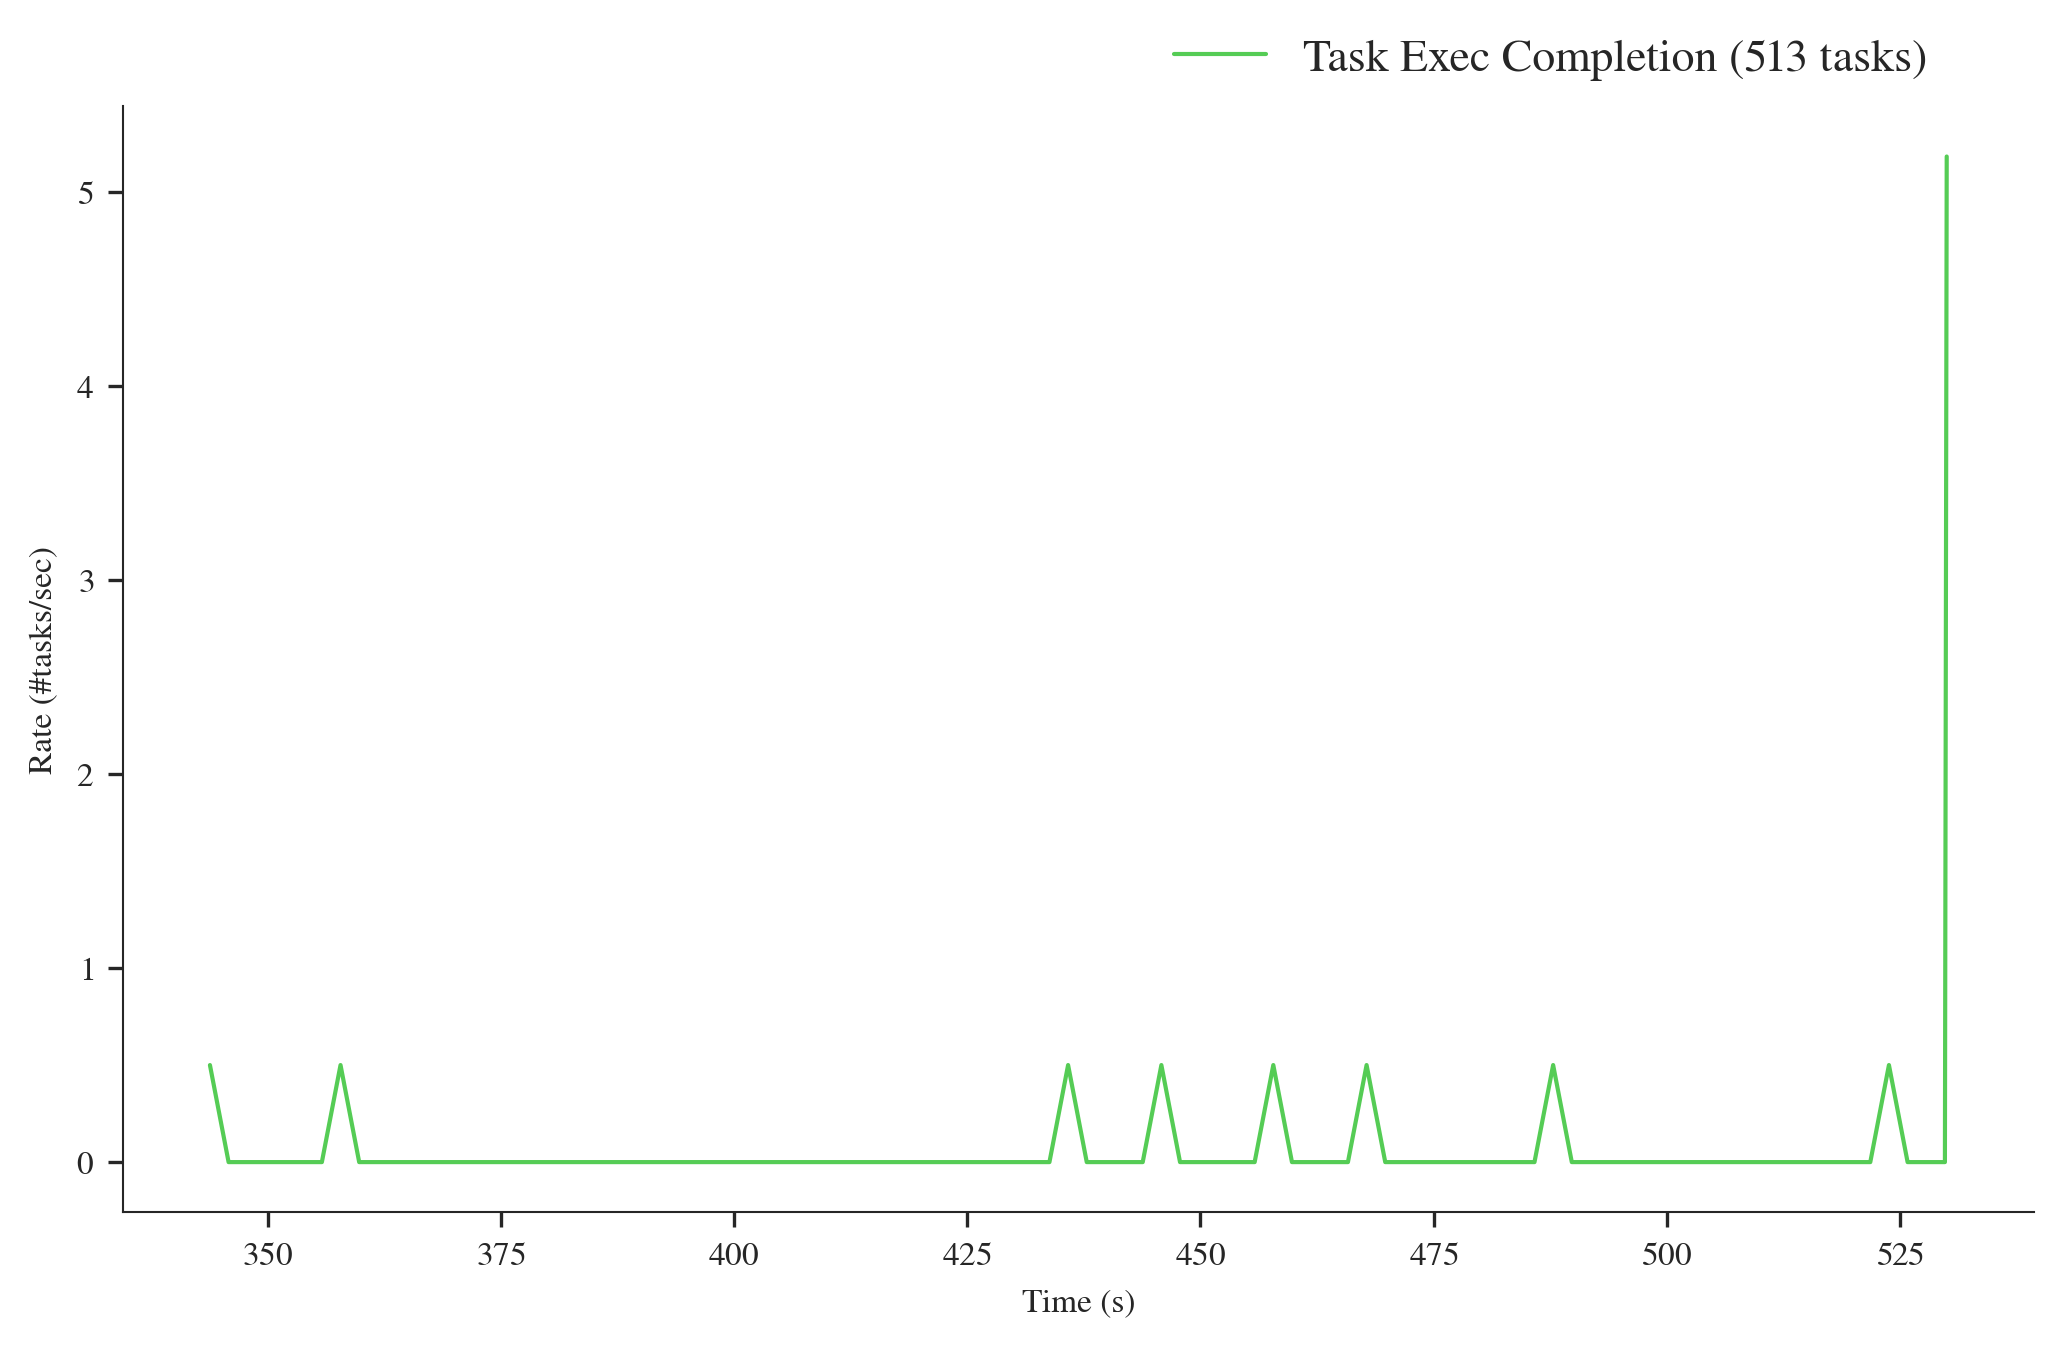

In [16]:
for k in ['8n']: #['1n', '2n', '4n', '8n']:
    exec_rate(v, save=True)

# TTX

In [17]:
def ttx(data_all, keys=None):
    query_dur = [{ru.EVENT: f'exec_start'},
                 {ru.EVENT: f'exec_stop'} ]
    
    keys = keys or list(data_all)
    
    durations = {}
    for name in keys:
        data = data_all[name]
        durations[name] = []
        for tid in data['tasks'].list('uid'):
            task = data['tasks'].get(etype='task', uid=tid)[0]
            durations[name].append(task.duration(event=query_dur))
    
    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

    data   = [durations[name] for name in durations]
    labels = ['%s:%s' % ((data_all[name]['pilot'].cfg['nodes'] - 1), len(durations[name])) 
                         for name in durations]

    ax.boxplot(data, labels=labels, patch_artist=True)

    ax.set_xlabel('Nodes:Tasks')
    ax.set_ylabel('Tasks TTX (s)')
    plt.tight_layout()

/tmp/ipykernel_90500/3342093609.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, patch_artist=True)


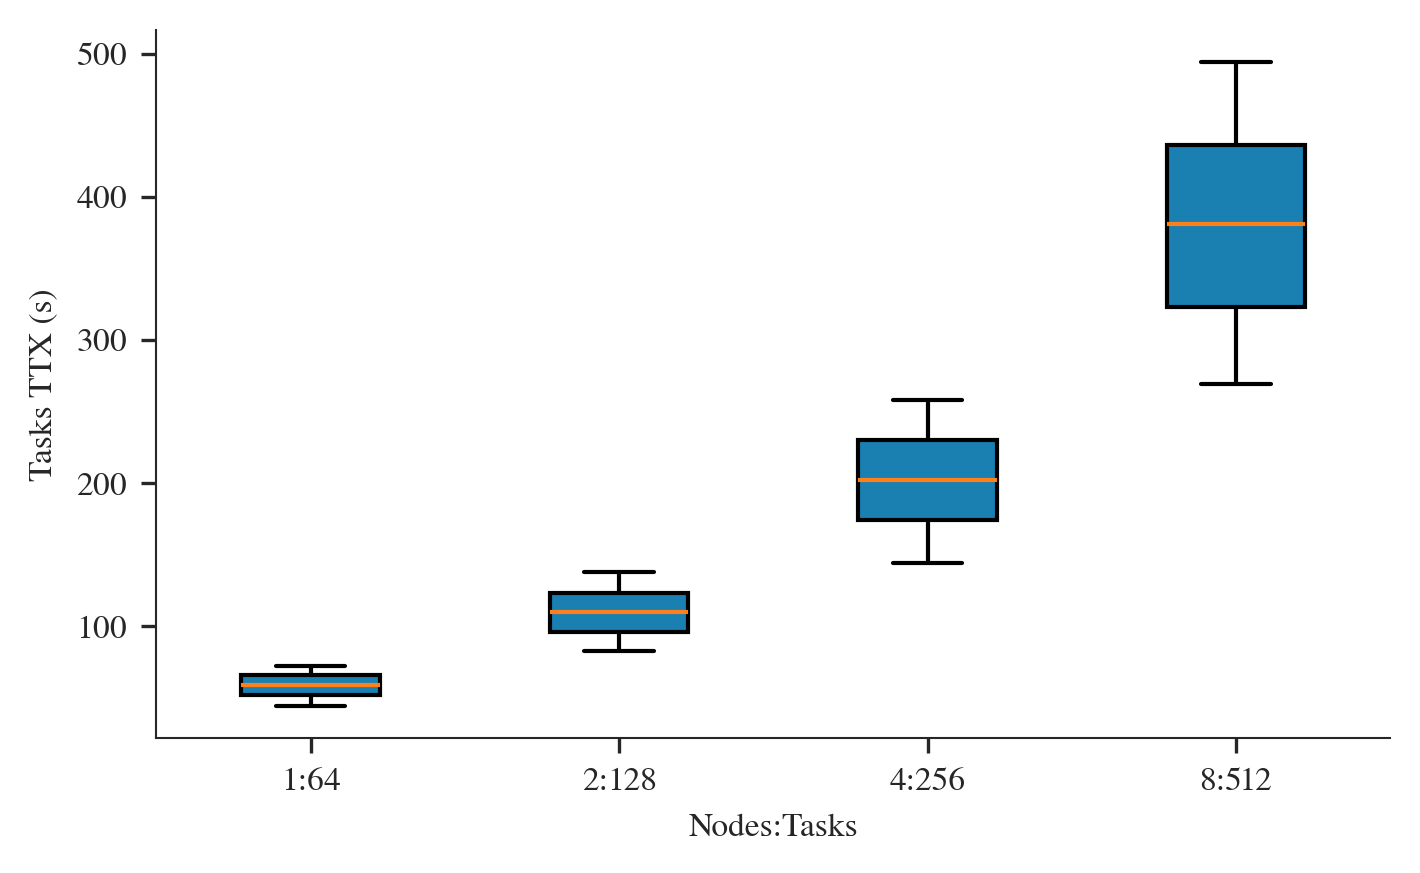

In [18]:
ttx(data, ['1n', '2n', '4n', '8n'])

In [19]:
def prompt_durations(data_all, keys=None):

    prompt_events = [{ru.EVENT: 'ollama_prompt_start'},
                     {ru.EVENT: 'ollama_prompt_stop'} ]
    
    keys = keys or list(data_all)
    
    durations = {}
    for name in keys:
        data = data_all[name]
        durations[name] = []
        for tid in data['tasks'].list('uid'):
            task = data['tasks'].get(etype='task', uid=tid)[0]
            ts_start = task.timestamps(event=prompt_events[0])
            ts_stop  = task.timestamps(event=prompt_events[1])
            durs = [(tsp[1] - tsp[0]) for tsp in zip(ts_start, ts_stop)]
            durations[name].extend(durs)
    
    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

    data   = [durations[name] for name in durations]
    labels = ['%s:%s' % ((data_all[name]['pilot'].cfg['nodes'] - 1), 
                          len(durations[name])//len(durs)) for name in durations]

    ax.boxplot(data, tick_labels=labels, patch_artist=True)

    ax.set_xlabel('Nodes:Tasks')
    ax.set_ylabel('Prompt durations (s)')
    plt.tight_layout()

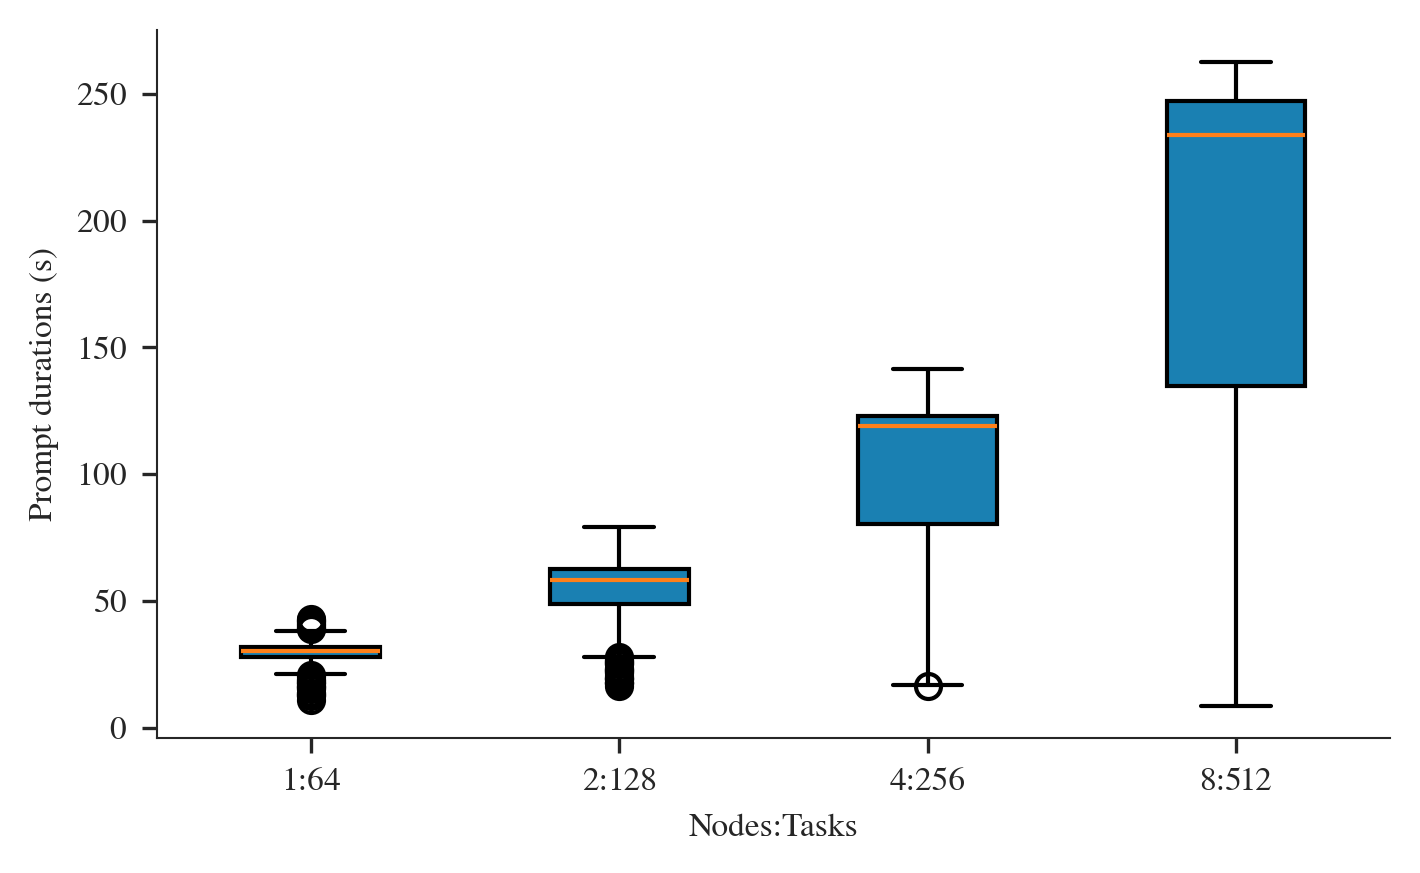

In [20]:
prompt_durations(data, ['1n', '2n', '4n', '8n'])

In [21]:
def prompt_ordered_durations(data_all, keys=None):

    prompt_events = [{ru.EVENT: 'ollama_prompt_start'},
                     {ru.EVENT: 'ollama_prompt_stop'} ]
    
    keys = keys or list(data_all)
    
    durations = {}
    for name in keys:
        data = data_all[name]
        durations.update({
            (name + '0'): [],
            (name + '1'): []
        })
        for tid in data['tasks'].list('uid'):
            task = data['tasks'].get(etype='task', uid=tid)[0]
            ts_start = task.timestamps(event=prompt_events[0])
            ts_stop  = task.timestamps(event=prompt_events[1])
            durs = [(tsp[1] - tsp[0]) for tsp in zip(ts_start, ts_stop)]
            durations[name + '0'].append(durs[0])
            durations[name + '1'].append(durs[1])
    
    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

    data   = [durations[name] for name in durations]
    labels = ['%s:%s:%s' % ((data_all[name[:2]]['pilot'].cfg['nodes'] - 1), 
                          len(durations[name]),
                          name[-1]) for name in durations]

    ax.boxplot(data, tick_labels=labels, patch_artist=True)

    ax.set_xlabel('Nodes:Tasks:PromptOrder')
    ax.set_ylabel('Prompt durations (s)')
    plt.tight_layout()

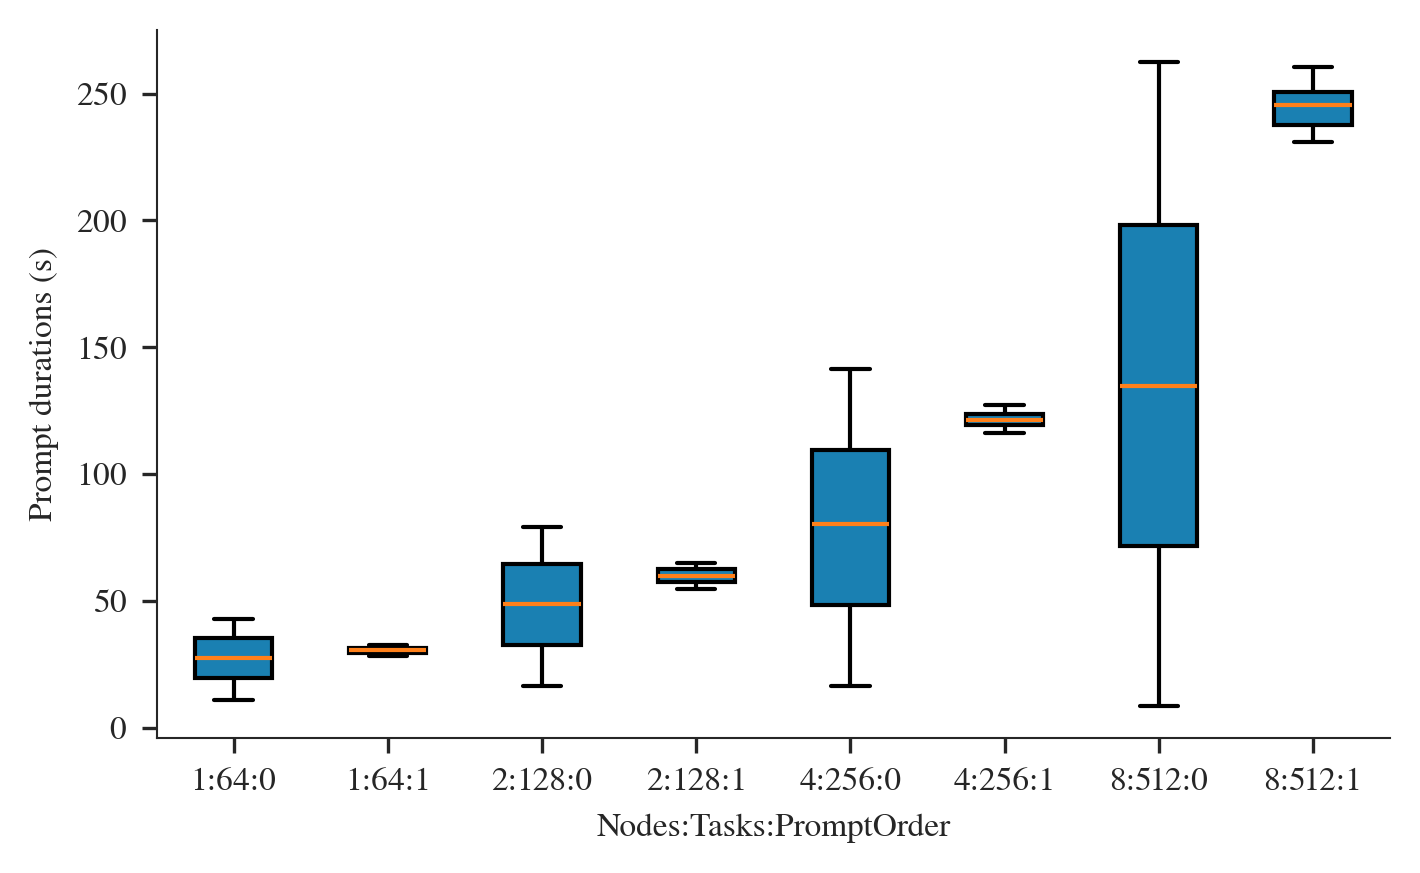

In [22]:
prompt_ordered_durations(data, ['1n', '2n', '4n', '8n'])

In [23]:
def prompt_base_duration(data_all, keys):

    prompt_events = [{ru.EVENT: 'ollama_prompt_start'},
                     {ru.EVENT: 'ollama_prompt_stop'} ]
    
    durations = []
    for name in keys:
        data = data_all[name]
        tid  = data['tasks'].list('uid')[0]
        task = data['tasks'].get(etype='task', uid=tid)[0]
        ts_start = task.timestamps(event=prompt_events[0])
        ts_stop  = task.timestamps(event=prompt_events[1])
        durations.append([(tsp[1] - tsp[0]) for tsp in zip(ts_start, ts_stop)])
    
    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

    labels = list(range(len(durations[0])))
    ax.boxplot(list(zip(*durations)), tick_labels=labels, patch_artist=True)

    ax.set_xlabel('Ordered prompts')
    ax.set_ylabel('Prompt durations (s)')
    plt.tight_layout()

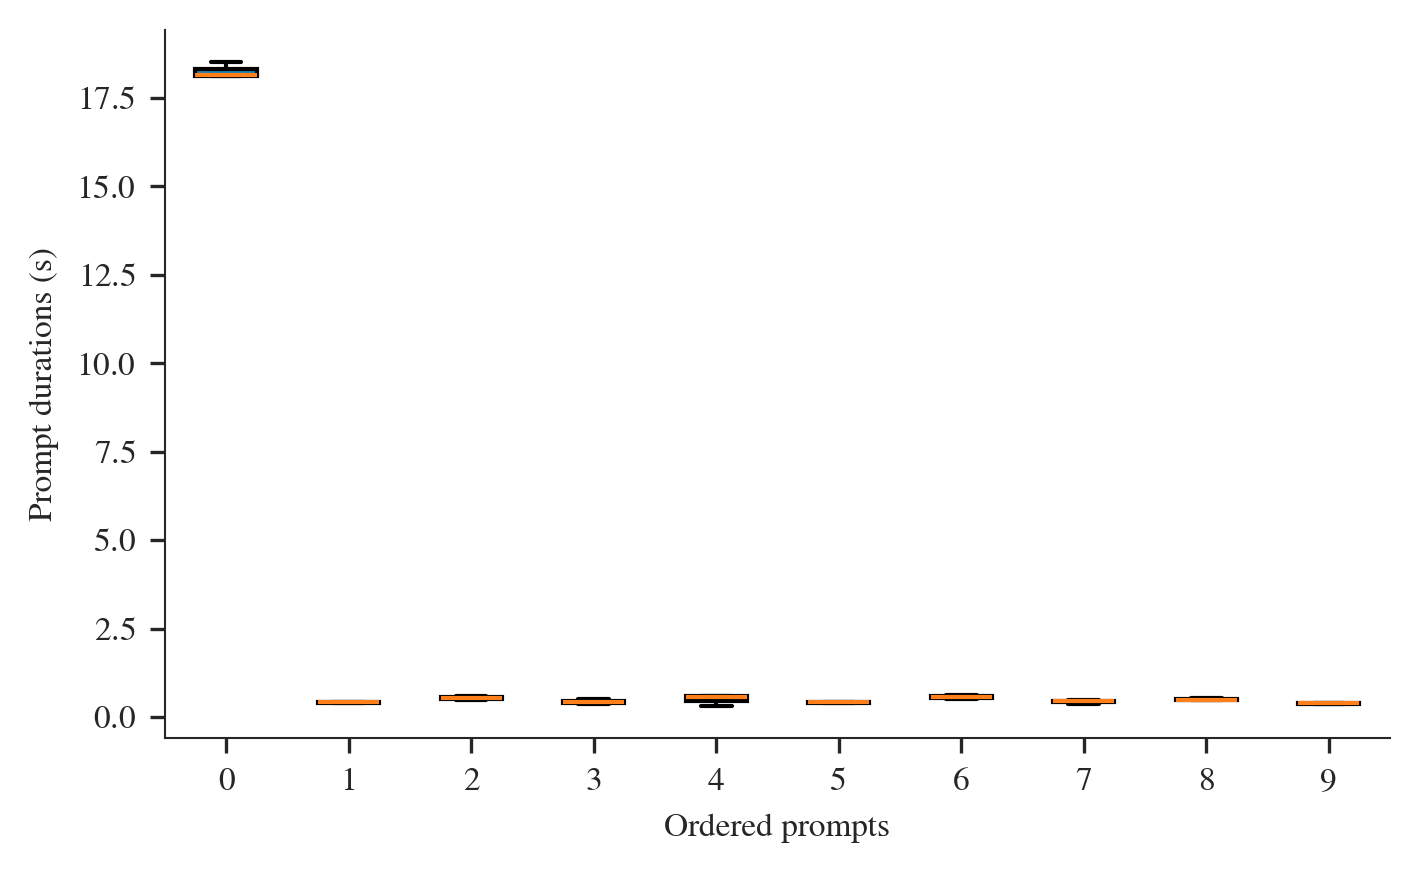

In [24]:
prompt_base_duration(data, ['1ta', '1tb', '1tc'])

In [25]:
def prompt_ordered_durations_with_probe(data_all, keys=None, parsing=True):

    prompt_events = [{ru.EVENT: 'ollama_prompt_start'},
                     {ru.EVENT: 'ollama_prompt_stop'} ]
    
    keys = keys or list(data_all)
    
    durations = {}
    if not parsing:
        for name in keys:
            data = data_all[name]
            durations.update({
                (name + '0'): [],
                (name + '1'): []
            })
            for tid in data['tasks'].list('uid'):
                task = data['tasks'].get(etype='task', uid=tid)[0]
                ts_start = task.timestamps(event=prompt_events[0])
                ts_stop  = task.timestamps(event=prompt_events[1])
                durs = [(tsp[1] - tsp[0]) for tsp in zip(ts_start, ts_stop)]
                durations[name + '0'].append(durs[0])
                durations[name + '1'].append(durs[1])
    else:
        for name in keys:
            data = data_all[name]
            durations.update({
                (name + '0'): [],
                (name + '1'): []
            })
            for tid in data['tasks'].list('uid'):
                with ru.ru_open(os.getcwd() + '/%s/%s/%s/%s.prof' % (data['sid'], data['pid'], tid, tid)) as fd:
                    previous_line = ''
                    idx = 0
                    for line in fd.readlines():
                        line = line.split('\n')[0]
                        if not line:
                            continue
                        p = line.split(',')
                        if p[1] == 'ollama_prompt_start':
                            prompt_start = float(p[0])
                        elif p[1] == 'ollama_prompt_stop':
                            durations[name + str(idx)].append(float(p[0]) - prompt_start)
                            idx += 1
                            idx %= 2
    
    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))

    data   = [durations[name] for name in durations]
    labels = ['%s:%s:%s' % ((data_all[name[:-1]]['pilot'].cfg['nodes'] - 1), 
                          len(durations[name]),
                          name[-1]) for name in durations]

    ax.boxplot(data, tick_labels=labels, patch_artist=True)

    ax.set_xlabel('Nodes:Tasks:PromptOrder')
    ax.set_ylabel('Prompt durations (s)')
    plt.tight_layout()

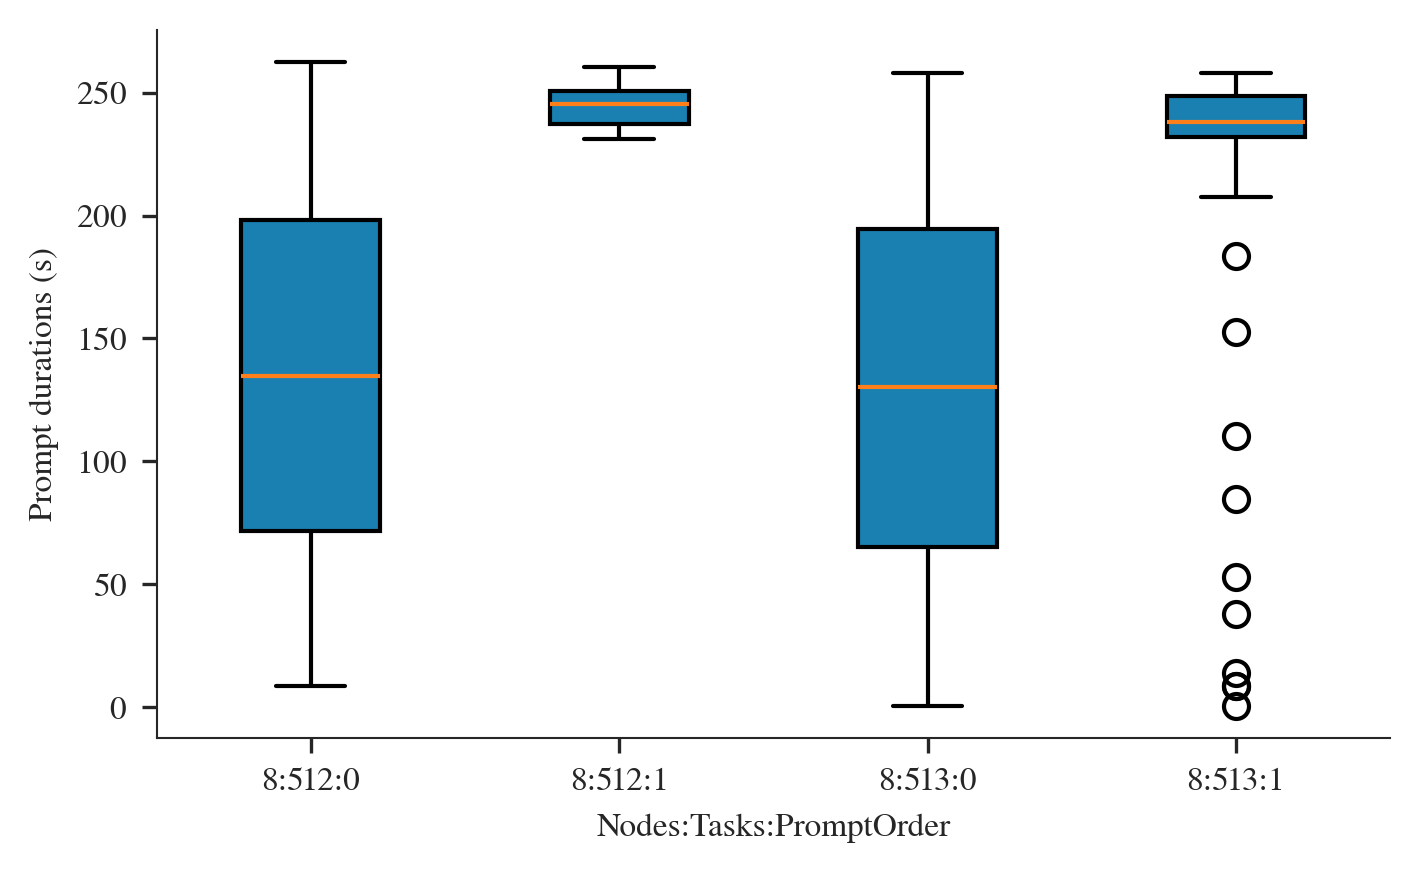

In [26]:
prompt_ordered_durations_with_probe(dict({'8n': data['8n'], '8npa': data['8npa']}), parsing=True)  #, '8npb': data['8npb']

In [27]:
def corr_prompt_chars_duration(data_all, keys=None):
    
    keys = keys or list(data_all)
    
    durations = defaultdict(list)
    for name in keys:
        data = data_all[name]
        for tid in data['tasks'].list('uid'):
            with ru.ru_open(os.getcwd() + '/%s/%s/%s/%s.prof' % (data['sid'], data['pid'], tid, tid)) as fd:
                previous_line = ''
                for line in fd.readlines():
                    line = line.split('\n')[0]
                    if not line:
                        continue
                    p = line.split(',')
                    if p[1] == 'ollama_prompt_start':
                        prompt_start = float(p[0])
                    elif p[1] == 'ollama_prompt_stop':
                        dur = float(p[0]) - prompt_start
                        num_chars = 0
                        if p[6]:
                            num_chars = int(p[6].split('prompt:')[1].split('|||')[1])
                        durations[num_chars].append(dur)

    fig, ax = plt.subplots(figsize=ra.get_plotsize(345))
    
    x, y = [], []
    for k in sorted(durations):
        for v in sorted(durations[k]):
            x.append(v)  # prompt duration
            y.append(k)  # number of characters in the response

    # ax.set_ylim([180, 250])
    # ax.yaxis.set_major_locator(mticker.MaxNLocator(3))
    ax.scatter(x, y)

    ax.set_xlabel('Prompt durations (s)')
    ax.set_ylabel('Number of characters in response')
    plt.tight_layout()

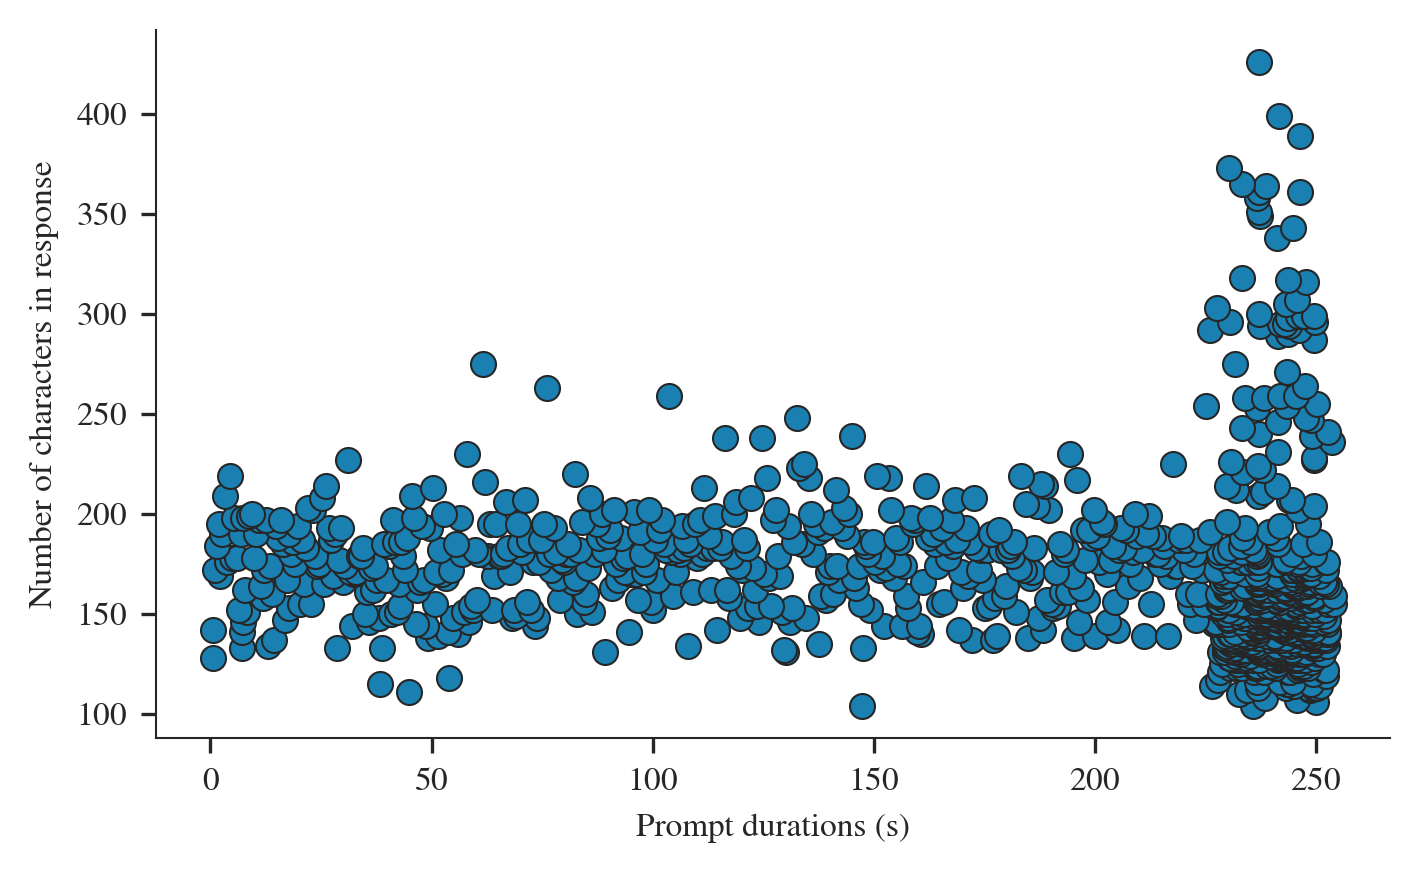

In [28]:
corr_prompt_chars_duration(data, ['8npb'])